# 总体回测前

## 设置参数

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
try:
    import empyrical as emp
except:
    emp = None
import tushare as ts
import time
import datetime
import random

from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq
from spider.spider_coinmarketcap import Spider_coinmarketcap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']
HS300 = list(ts.get_hs300s()['code'])

BENCHMARK = '399300'
# TARGET = ['399300']
TARGET = HS300

ALL_TARGET = TARGET[:]

pd

<module 'pandas' from 'd:\\python36\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

### 时间设置
# start_date = '2005-01-01'
# start_date = '2006-01-01'
# start_date = '2007-01-01'
# start_date = '2008-01-01'
# start_date = '2009-01-01'
# start_date = '2010-01-01'
# start_date = '2011-01-01'
# start_date = '2012-01-01'
# start_date = '2013-01-01'
# start_date = '2014-01-01'
# start_date = '2015-01-01'
# start_date = '2015-07-01'
# start_date = '2016-01-01'
start_date = '2017-01-01'
# start_date = '2018-01-01'
# start_date = '2018-08-01'
# end_date = '2016-01-01'
# end_date = '2018-08-01'
end_date = time.strftime('%Y-%m-%d')

TURTLE_POS = 20
### Turtle System One - Short
TURTLE_SHORT_BUY_N = 20
TURTLE_SHORT_SELL_N = 20
### Turtle System Two - Long
TURTLE_LONG_BUY_N = 60
TURTLE_LONG_SELL_N = 60

### 业务设置
IS_HAPPYMONEY = False
IS_TAX = False
IS_SLIPPAGE = False
IS_RANDOM_BUY = False
IS_FILTER = False
IS_MARKETUP = True
IS_BUYBENCHMARK = True
IS_SHOWBUYLIST = True
START_MONEY = 10000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY

Wall time: 0 ns


# 每天开盘前

## 是否交易日

In [ ]:
# today = datetime.date.today().strftime('%Y-%m-%d')
# lastweek = (datetime.date.today()  - datetime.timedelta(days=7)).strftime('%Y-%m-%d')
# df = ts.get_k_data(code='399300', index=True, start=lastweek, end=today)
# df

# if df.iloc[-1].date == today:
#     is_today_trading = True
# else:
#     is_today_trading = False
# #     return False

## 准备历史数据

In [3]:
%%time

stock_df_dict = {}

for symbol in TARGET + [BENCHMARK]:
    stock_data_file = '../database/market/%s_lite.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ100:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    if symbol in NASDAQ100 or symbol in CRYPTOCURRENCY:
        stock_df = stock_df[::-1]
    stock_df.set_index(['date'], inplace=True)
    stock_df.index = stock_df.index.to_period('D')

    # 计算每天涨跌幅
    stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
    stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.close.shift(1)) / stock_df.close.shift(1)
    
    # Turtle指标
    stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
    stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
    stock_df['MA180'] = stock_df['open'].rolling(180).mean()
    stock_df['MA90'] = stock_df['open'].rolling(90).mean()
    stock_df['MA60'] = stock_df['open'].rolling(60).mean()
    stock_df['MA30'] = stock_df['open'].rolling(30).mean()
    
    # 减少数据
    # stock_df = stock_df['2016-01-01':]
    stock_df.dropna(how='any', inplace=True)
    
    stock_df_dict[symbol] = stock_df

Wall time: 3.62 s


## 抽查数据

In [4]:
stock_df_dict[BENCHMARK].head(2)
stock_df_dict[BENCHMARK].tail(2)

df = stock_df_dict[BENCHMARK].iloc[:].copy()
df.columns
df.reset_index(drop=False, inplace=True)
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
df.set_index('date', inplace=True)
display_charts(df, chart_type='stock', kind='line', y=['open', 'ROLLING_60_MAX', 'ROLLING_60_MIN', 'MA60', 'MA180'], figsize=(900, 600))

,open,close,o_pct_chg,c_o_pct_chg,ROLLING_60_MAX,ROLLING_60_MIN,MA180,MA90,MA60,MA30
date,,,,,,,,,,
2017-09-25,3829.22,3817.79,0.000721,-0.002217,3851.69,3611.9,3548.587111,3676.953667,3748.519167,3801.640333
2017-09-26,3810.33,3820.78,-0.004933,-0.001954,3851.69,3611.9,3551.344778,3681.565889,3751.244167,3805.458667


,open,close,o_pct_chg,c_o_pct_chg,ROLLING_60_MAX,ROLLING_60_MIN,MA180,MA90,MA60,MA30
date,,,,,,,,,,
2018-09-19,3262.00,3312.48,0.021405,-0.002273,3589.51,3193.64,3765.346500,3507.664333,3374.710333,3304.670667
2018-09-20,3314.88,3310.13,0.016211,0.000725,3589.51,3193.64,3761.288722,3501.053889,3372.709333,3305.050667


Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'ROLLING_60_MAX',
       'ROLLING_60_MIN', 'MA180', 'MA90', 'MA60', 'MA30'],
      dtype='object')

## 准备订单数据

In [ ]:
# get_order

## 计算现金和总资产

In [ ]:
# get_cash

## 关注临界卖出目标

## 关注临界买入目标

In [5]:
watch_buy_df = None
watch_buy_df = pd.DataFrame(columns=[
    'date', 'symbol', 'open', 'ROLLING_MAX', 'minus'
])

today = pd.to_datetime(time.strftime('%Y-%m-%d'))
today = today.to_period(freq='D')
'today', today

for symbol in TARGET + [BENCHMARK]:
    if len(stock_df_dict[symbol]) == 0:
        continue
    yesterday_market = stock_df_dict[symbol].iloc[-1]
    if today - yesterday_market.name > 3:
        continue
    watch_buy_df = watch_buy_df.append(
        {
            'date': yesterday_market.name,
            'symbol': symbol,
            'open': yesterday_market.open,
            'ROLLING_MAX': yesterday_market['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N],
            'minus': (yesterday_market['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] - yesterday_market.open) / yesterday_market.open
        },
        ignore_index=True
    )

# watch_buy_df.sort_values(by='date')
watch_buy_df.sort_values(by='minus')[:10]

('today', Period('2018-09-20', 'D'))

,date,symbol,open,ROLLING_MAX,minus
9,2018-09-19,600023,5.08,5.08,0.0
129,2018-09-19,601288,3.64,3.64,0.0
207,2018-09-19,000709,3.13,3.13,0.0
130,2018-09-19,601318,64.09,64.09,0.0
11,2018-09-19,600028,6.80,6.80,0.0
190,2018-09-19,000166,4.51,4.51,0.0
82,2018-09-19,600688,5.75,5.75,0.0
125,2018-09-19,601225,8.25,8.25,0.0
57,2018-09-19,600406,17.19,17.19,0.0
155,2018-09-19,601818,3.83,3.83,0.0


# 每天交易时

## 第一时间获取开盘价

In [6]:
%%time

today_open_market = ts.get_today_all()
print('')
print('len(today_open_market)', len(today_open_market))

[Getting data:]############################################################
len(today_open_market) 3616
Wall time: 58.4 s


## 执行卖出


## 计算买入信号

BENCHMARK 399300
LASTDAY 2018-09-20
OPEN 3314.88
MA60 3372.7093333333323
MA180 3761.2887222222203
MARKET IS DOWN, STOP BUYING!


'今天买入目标'

,today,symbol,name,now_open,o_c_chg,reason,now_vol,ret_lastyear,p_date,RO60_MAX,p_open,p_close,MA60,MA90,MA180
0,2018-09-20,601888,中国国旅,64.37,0.22,,1140,0.920584,2018-09-19,73.850,63.12,64.23,64.597,64.568,58.280
1,2018-09-20,300015,爱尔眼科,29.28,-0.31,,649,0.777061,2018-09-19,35.400,29.19,29.37,31.469,31.580,28.416
2,2018-09-20,002493,荣盛石化,11.00,0.27,,1259,0.665132,2018-09-19,12.000,10.85,10.97,11.062,10.844,10.472
3,2018-09-20,600436,片仔癀,94.60,0.00,,323,0.605216,2018-09-19,128.870,91.95,94.60,107.747,108.889,93.973
4,2018-09-20,300122,智飞生物,43.59,0.79,,685,0.595184,2018-09-20,52.800,43.59,43.25,43.081,44.041,38.587
5,2018-09-20,603288,海天味业,70.93,-1.21,,271,0.581635,2018-09-20,77.760,70.93,71.80,70.264,71.632,64.444
6,2018-09-20,600588,用友网络,26.80,-0.30,,1637,0.467619,2018-09-19,30.160,26.31,26.88,26.231,25.849,24.797
7,2018-09-20,600271,航天信息,28.28,0.00,,1281,0.459971,2018-09-19,31.000,27.30,28.28,27.266,26.503,24.214
8,2018-09-20,600585,海螺水泥,35.49,1.52,,3149,0.421513,2018-09-19,39.180,35.10,34.96,35.638,35.136,33.535
9,2018-09-20,002153,石基信息,34.01,-0.29,,658,0.412489,2018-09-19,39.000,33.50,34.11,32.959,31.507,28.934


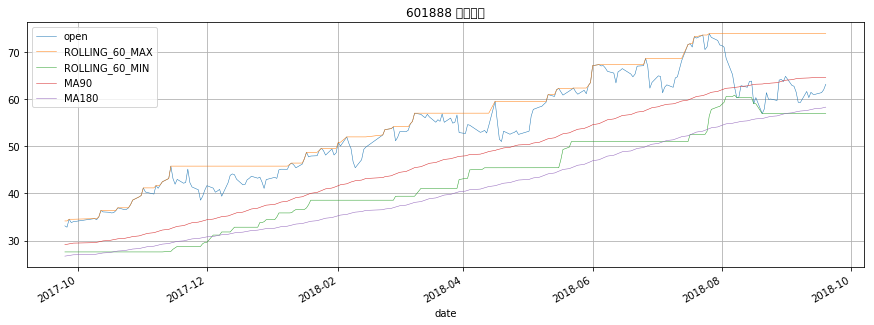

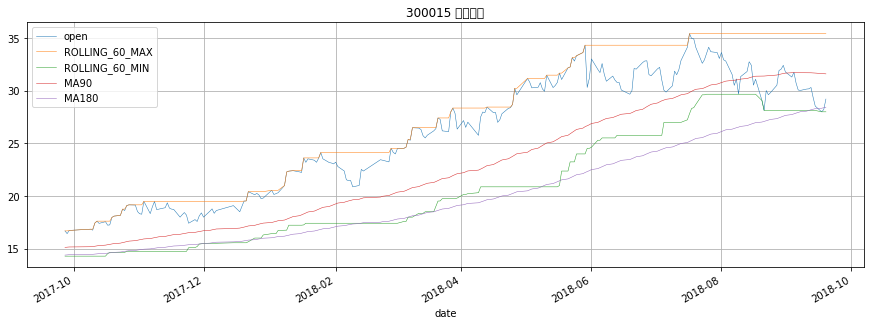

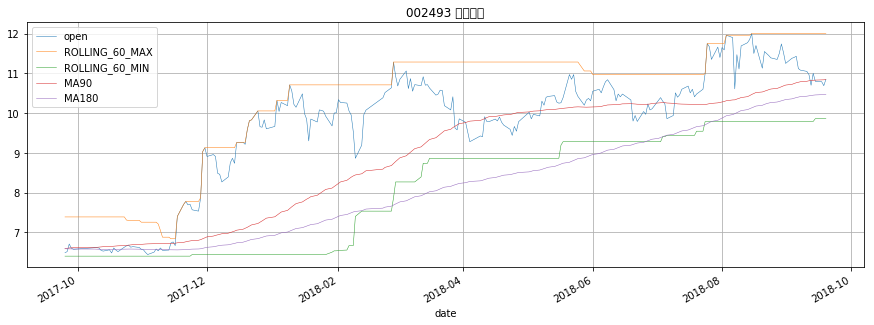

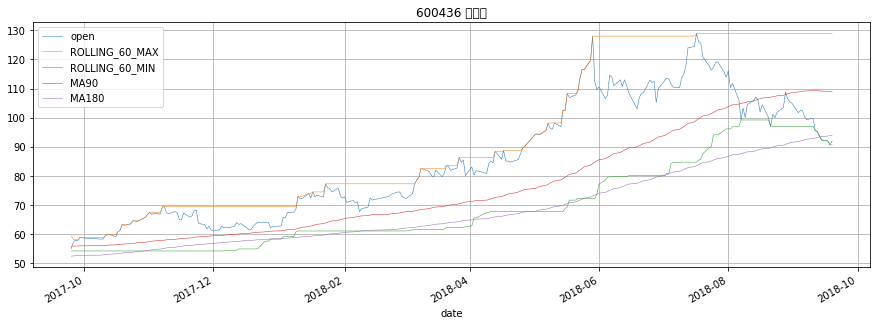

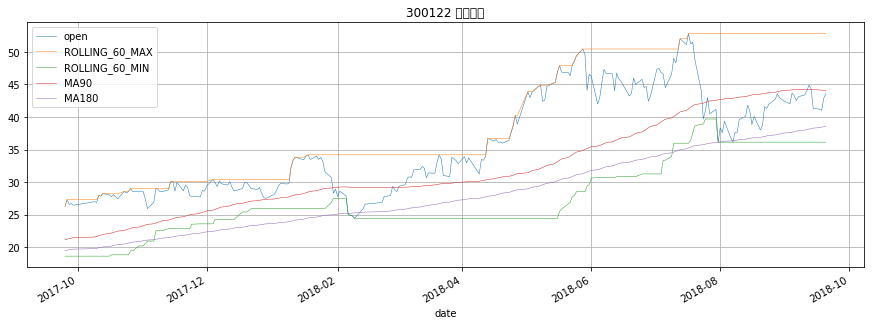

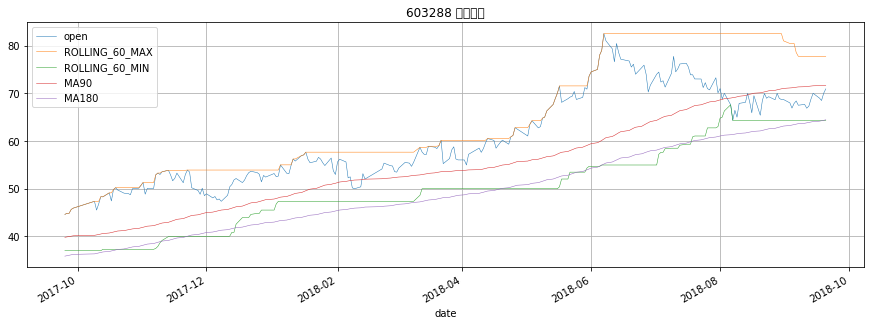

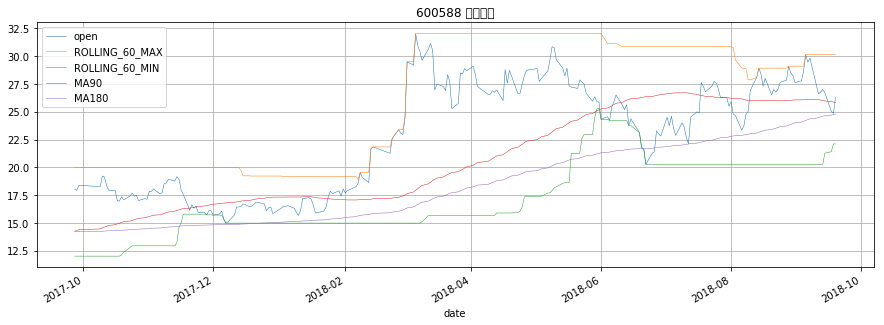

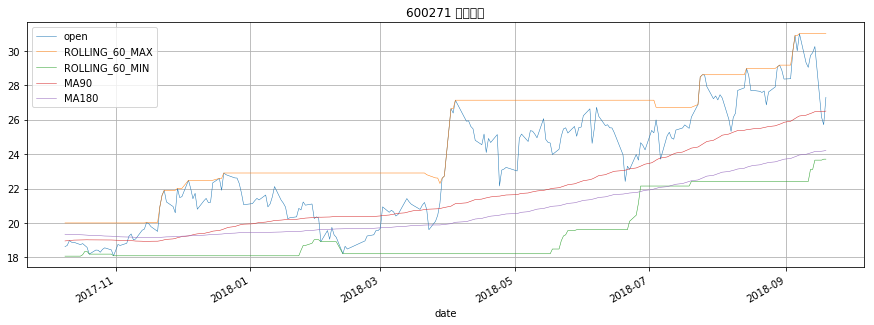

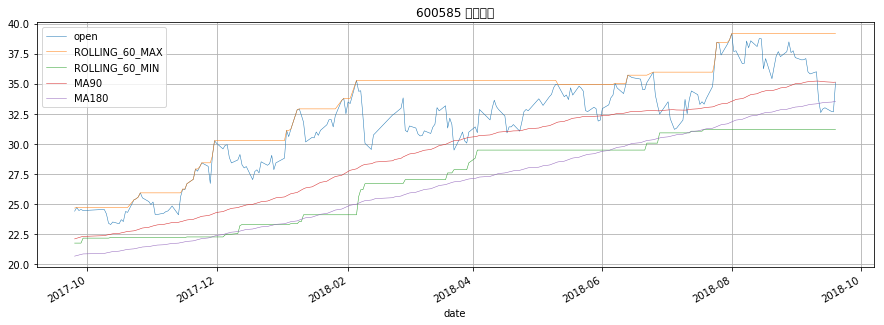

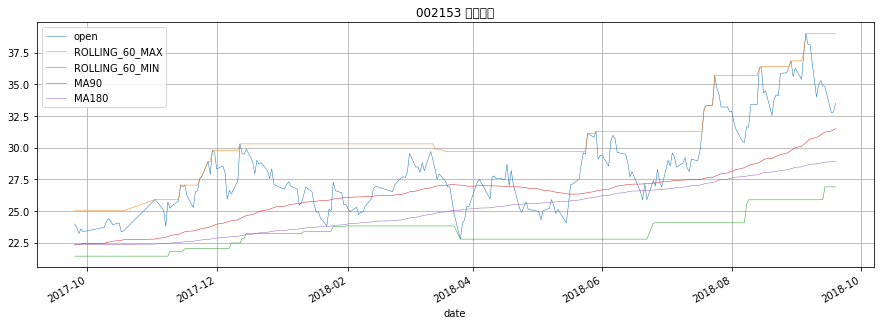

In [22]:
today = pd.to_datetime(time.strftime('%Y-%m-%d'))
today = today.to_period(freq='D')

benchmark_lastday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-1]
benchmark_today_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-1]

target_today_market = today_open_market.copy()
target_today_market.set_index(keys='code', inplace=True)
# target_today_market[:10]
# stock_df_dict['600000']
# target_today_market.loc['600000']
buy_list = []

# 趋势交易，只在好行情时买入
is_market_up = True
if IS_MARKETUP:
    if benchmark_lastday_market.MA60 < benchmark_lastday_market.MA180:
        print('BENCHMARK', BENCHMARK)
        print('LASTDAY', benchmark_lastday_market.name)
        print('OPEN', benchmark_lastday_market.open)
        print('MA60', benchmark_today_market.MA60)
        print('MA180', benchmark_today_market.MA180)
        print('MARKET IS DOWN, STOP BUYING!')
        is_market_up = False


# 遍历标的，判断和执行买入
for symbol in TARGET:
#     print(symbol)
    
    if not is_market_up:
        pass
#         break

    if len(stock_df_dict[symbol]) == 0:
        continue

    today_market = target_today_market.loc[symbol]
#     today_market
    lastday_market = stock_df_dict[symbol].loc[:today].iloc[-1]
#     lastday_market
    
#     if today - lastday_market.name > 3:
#         continue

    # 突破上行趋势，就买一份
    is_buy = False
    buy_reason = ''

    # 指数就不要过滤器了
    if True:
        if lastday_market.MA90 >= lastday_market.MA180:
            is_buy = True
            buy_reason += 'MA'
        if today_market.open >= lastday_market['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N]:
            is_buy = True
            buy_reason += 'LONG'
        if False and today_market.open >= lastday_market['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N]:
            is_buy = True
            buy_reason += 'SHORT'

    # 加入购买信号列表
    if is_buy:
        buy_list.append(symbol)


if IS_RANDOM_BUY:
    random.shuffle(buy_list)
else:
    tmp_list = []
    for symbol in buy_list:
        try:
            return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[-250].open - 1
        except:
            return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[1].open - 1
        tmp_list.append((return_lastyear, symbol))
    tmp_list = sorted(tmp_list, reverse=True)
    buy_list = [x for x in tmp_list if x[0]>0]
#     buy_list = [x[1] for x in tmp_list]
#     buy_list = tmp_list


buy_list_df = None
buy_list_df = pd.DataFrame(columns=[
    'today', 'symbol', 'name', 
    'now_open', 'o_c_chg', 'reason', 'now_vol', 'ret_lastyear',
    'p_date', 'RO60_MAX', 'p_open', 'p_close',
    'MA60', 'MA90', 'MA180', 
#     'per', 'pb',
])
for return_lastyear, symbol in buy_list:
    today_market = target_today_market.loc[symbol]
    lastday_market = stock_df_dict[symbol].loc[:today].iloc[-1]
    buy_list_df = buy_list_df.append(
        {
            'today': today,
            'symbol': symbol,
            'name': today_market['name'],
            'reason': buy_reason,
            'now_open': today_market.open,
            'p_date': lastday_market.name,
            'RO60_MAX': lastday_market.ROLLING_60_MAX,
            'p_open': lastday_market.open,
            'p_close': lastday_market.close,
            'o_c_chg': '%.2f' % ((today_market.open - lastday_market.close) * 100 / lastday_market.close),
            'MA60': '%.3f' % lastday_market.MA60,
            'MA90': '%.3f' % lastday_market.MA90,
            'MA180': '%.3f' % lastday_market.MA180,
            'now_vol': int(today_market.volume / 10000),
            'ret_lastyear': return_lastyear,
#             'per': today_market.per,
#             'pb': today_market.pb,
        },
        ignore_index = True
    )


'''今天买入目标'''
buy_list_df



%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
for i in range(len(buy_list_df[:10])):
    symbol = buy_list_df.iloc[i].symbol
    name = buy_list_df.iloc[i]['name']
    df = stock_df_dict[symbol].copy()
    df.reset_index(drop=False, inplace=True)
    df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
    df.set_index('date', inplace=True)
#     display_charts(
#         df, chart_type='stock', title='%s %s' % (symbol, name), 
#         y=['open', 'ROLLING_60_MAX', 'ROLLING_60_MIN', 'MA60', 'MA180'], 
#         figsize=(900, 600)
#     )
    ax = df.plot(title='%s %s' % (symbol, name), kind='line', 
                 y=['open', 'ROLLING_60_MAX', 'ROLLING_60_MIN', 'MA90', 'MA180'], 
                 linewidth=0.5, grid=True)

In [ ]:
## 计算买入份额

## 人工执行/记录买入

In [ ]:
CASH = 100000
PROPERTY = 100000
CASH_PER_SYMBOL = PROPERTY / TURTLE_POS
buy_symbol_count = int(CASH / CASH_PER_SYMBOL)
print('CASH=%d, PROPERTY=%d, CASH_PER_SYMBOL=%d, CAN_BUY_SYMBOL=%d' %
          (CASH, PROPERTY, CASH_PER_SYMBOL, buy_symbol_count)
    )

if buy_symbol_count == 0:
    pass
#     return False

for i in range(len(buy_list_df)):
    today_market = buy_list_df.loc[i]
    buy_count = int(CASH_PER_SYMBOL / today_market.now_open)
    buy_list_df.loc[i, 'buy_cnt'] = buy_count
#     buy_list_df.astype({'buy_cnt': 'int'})
    buy_list_df.astype(dtype={'buy_cnt': 'int'})

buy_list_df

enter_buy_list = []
input_data = None
print('每次输入一支股票的代码和买入数目，如600028,1445')
print('结束请输入end')
while True:
    input_data = input()
    if input_data == 'end':
        print('输入完毕！')
        break
    input_data = input_data.split(',')
    enter_buy_list.append((input_data[0], input_data[1]))

'买入列表'
enter_buy_list



order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'name', 'buy_count', 'buy_price', 'buy_reason', 
    'sell_date', 'sell_price', 'sell_reason', 'profit', 
    'cash', 'property'
])

ops_df = None
ops_df = pd.DataFrame(columns=[
    'ops_date', 'ops', 'symbol', 'name', 'count', 'price', 'reason', 'profit'
])


for buy_item in enter_buy_list:
    today_market = buy_list_df[buy_list_df['symbol'] == buy_item[0]].iloc[0]
#     today_market
    CASH = CASH - int(today_market.now_open) * int(buy_item[1])
    order_df = order_df.append(
        {
            'buy_date': today,
            'symbol': today_market.symbol,
            'name': today_market['name'],
            'buy_count': int(buy_item[1]),
            'buy_price': today_market.now_open,
            'buy_reason': 'ROLLING60MAX',
            'sell_date': pd.np.nan,
            'sell_price': 0,
            'profit': 0,
            'cash': CASH,
            'property': PROPERTY,
        },
        ignore_index=True
    )
    ops_df = ops_df.append(
        {
            'ops_date': today,
            'ops': 'BUY',
            'symbol': today_market.symbol,
            'name': today_market['name'],
            'count': int(buy_item[1]),
            'price': today_market.now_open,
            'reason': 'ROLLING60MAX',
            'profit': 0,
        },
        ignore_index=True
    )

order_df
ops_df
CASH
PROPERTY

# 每天收盘后

## 下载数据到本地

In [ ]:
%%time

IS_DOWNLOAD_DATA = False
ignore = True

for symbol in TARGET + [BENCHMARK]:
    if not IS_DOWNLOAD_DATA:
        break

    # 沪深300指数
    if symbol == '399300':
        df = ts.get_k_data(code=symbol, index=True, start='2017-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s_lite.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # A股
    elif symbol in HS300:
        df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2017-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s_lite.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')

    print(datafile)
    time.sleep(1)

In [ ]:
# df = ts.get_k_data(code='399300', index=True, start='2018-08-01', end=time.strftime('%Y-%m-%d'))
# df